## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-aiplatform japanize_matplotlib

In [ ]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [7]:
import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [8]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

model_flash = GenerativeModel('gemini-1.5-flash')

In [9]:
def create_cached_model(movie_file, model_name='gemini-1.5-pro-001', ttl=60):
    prompt_cached = [
        '[movie file]',
        Part.from_uri(movie_file, mime_type='video/mp4'),
    ]
    cached_content = caching.CachedContent.create(
        model_name=model_name,
        contents=prompt_cached,
        ttl=datetime.timedelta(minutes=ttl)
    )
    model = GenerativeModel.from_cached_content(cached_content=cached_content)
    return model

In [10]:
def generate(prompt, model, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [11]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

## 対象動画をキャッシング

In [12]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2024-09-21T01:35:04Z  gs://your-project-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2024-09-21T01:39:05Z  gs://your-project-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2024-09-21T01:40:53Z  gs://your-project-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


In [13]:
target_s = f'{BUCKET}/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4'
model = create_cached_model(target_s, ttl=300)

# ファイル名の先頭が n_ の無音動画ファイルを指定すること
target_n = f'{BUCKET}/mp4/n_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4'
model_noaudio = create_cached_model(target_n, ttl=300)

**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [14]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [16]:
prompt_identify_characters = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

In [17]:
result = generate(prompt_identify_characters, model=model)

[
  {
    "Character ID": 1,
    "Name": "郷 豪",
    "Visual Description": "郷さんは黒いTシャツを着ています。髪は黒く、短髪です。肌の色は少し日焼けしているように見えます。",
    "Scenes": [
      "00:06-00:34",
      "00:51-01:19",
      "02:25-02:36"
    ]
  },
  {
    "Character ID": 2,
    "Name": "小栗 香苗",
    "Visual Description": "小栗さんは白いトップスにベージュのスカートを履いています。髪は茶色で長く、後ろで一つに結んでいます。",
    "Scenes": [
      "00:06-00:34",
      "00:51-01:19",
      "06:01-06:55"
    ]
  },
  {
    "Character ID": 3,
    "Name": "佐々木茜",
    "Visual Description": "佐々木さんは黒いTシャツに花柄のロングスカートを履いています。髪は黒く、短髪です。",
    "Scenes": [
      "01:27-01:52",
      "03:25-03:44"
    ]
  },
  {
    "Character ID": 4,
    "Name": "山田 唯",
    "Visual Description": "山田さんは白いTシャツにベージュのショートパンツを履いています。髪は黒く、短髪です。",
    "Scenes": [
      "03:55-04:20",
      "04:22-06:00"
    ]
  },
  {
    "Character ID": 5,
    "Name": "Unknown",
    "Visual Description": "白いTシャツにベージュのショートパンツを履いています。髪は黒く、短髪です。",
    "Scenes": [
      "04:22-06:00"
    ]
  },
  {
    "Character ID": 6,
    

=====
1 郷 豪 郷さんは黒いTシャツを着ています。髪は黒く、短髪です。肌の色は少し日焼けしているように見えます。


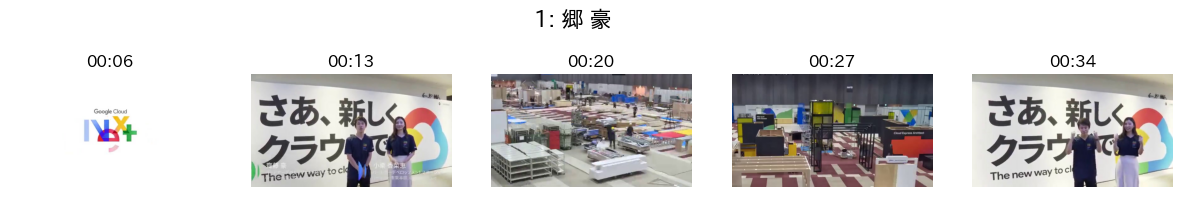

<Figure size 640x480 with 0 Axes>

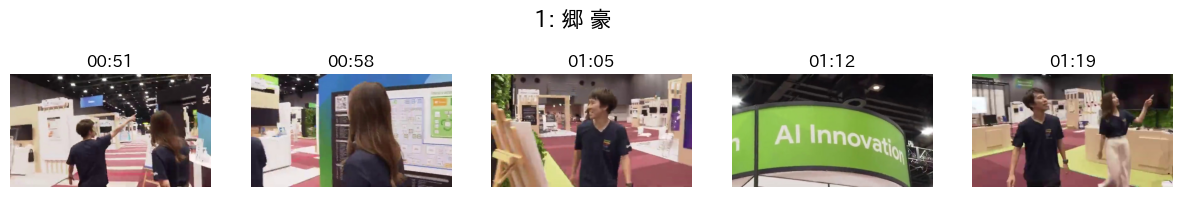

<Figure size 640x480 with 0 Axes>

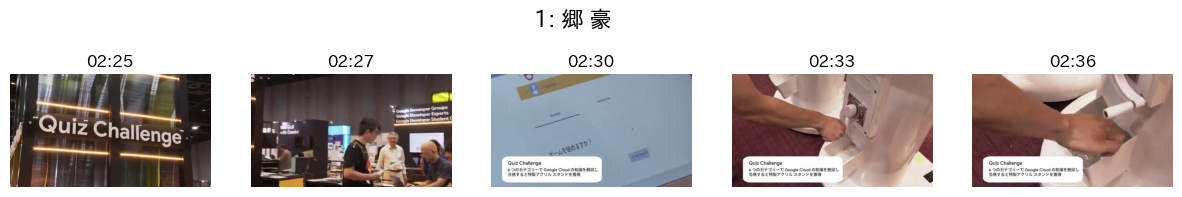

=====
2 小栗 香苗 小栗さんは白いトップスにベージュのスカートを履いています。髪は茶色で長く、後ろで一つに結んでいます。


<Figure size 640x480 with 0 Axes>

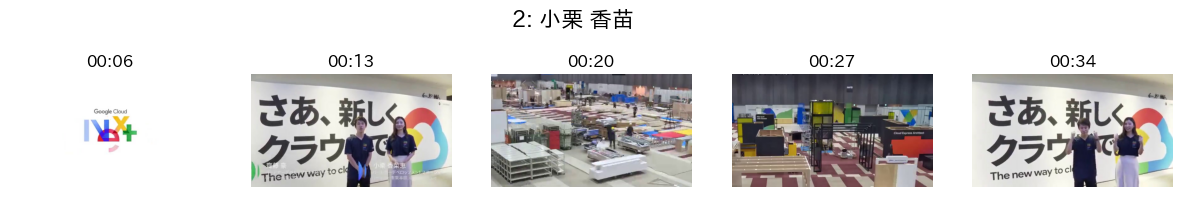

<Figure size 640x480 with 0 Axes>

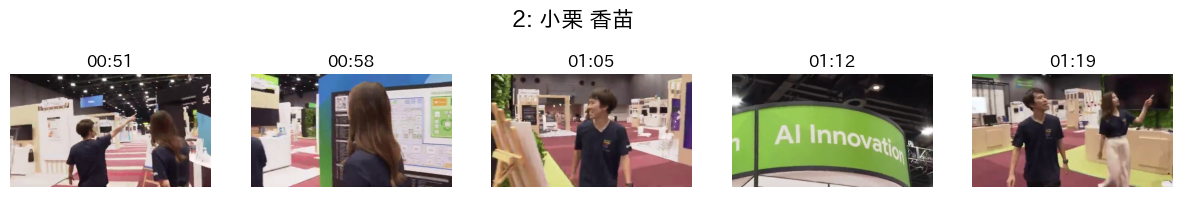

<Figure size 640x480 with 0 Axes>

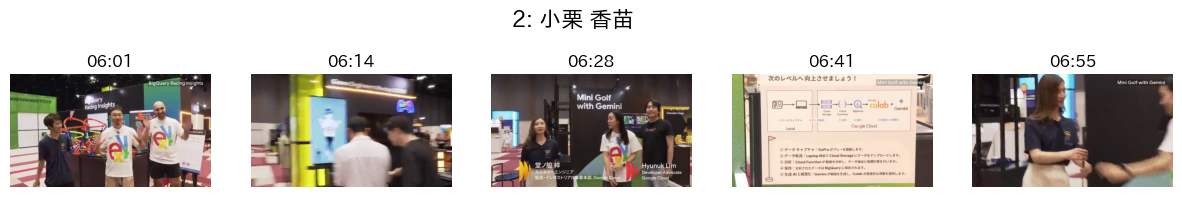

=====
3 佐々木茜 佐々木さんは黒いTシャツに花柄のロングスカートを履いています。髪は黒く、短髪です。


<Figure size 640x480 with 0 Axes>

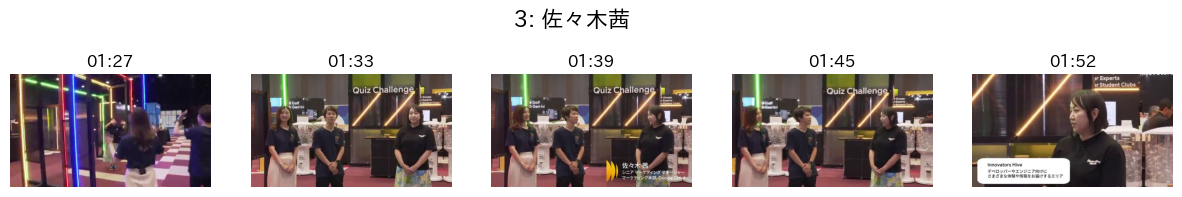

<Figure size 640x480 with 0 Axes>

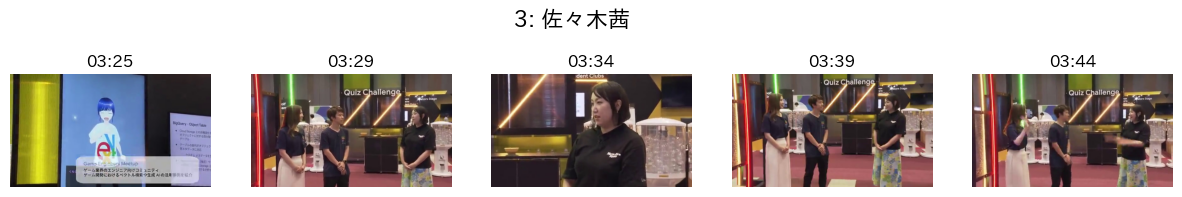

=====
4 山田 唯 山田さんは白いTシャツにベージュのショートパンツを履いています。髪は黒く、短髪です。


<Figure size 640x480 with 0 Axes>

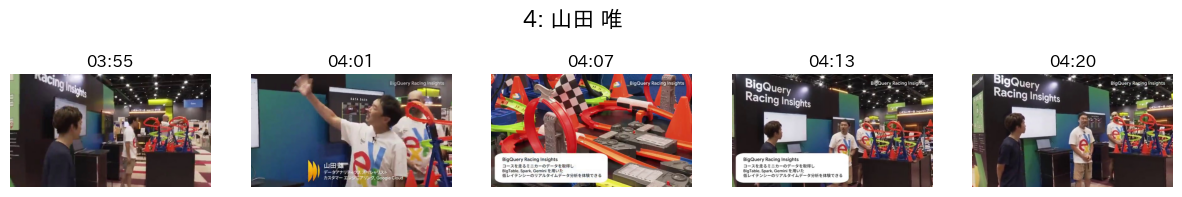

<Figure size 640x480 with 0 Axes>

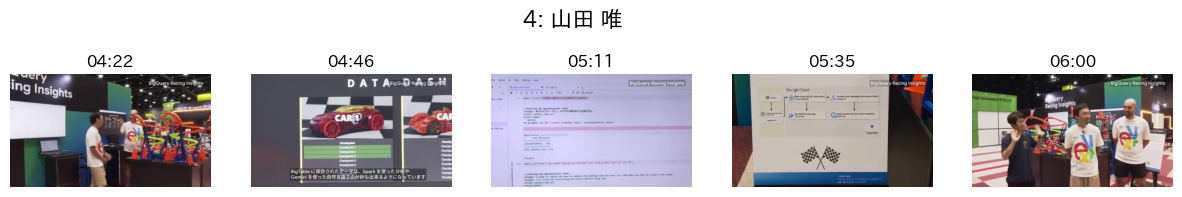

=====
5 Unknown 白いTシャツにベージュのショートパンツを履いています。髪は黒く、短髪です。


<Figure size 640x480 with 0 Axes>

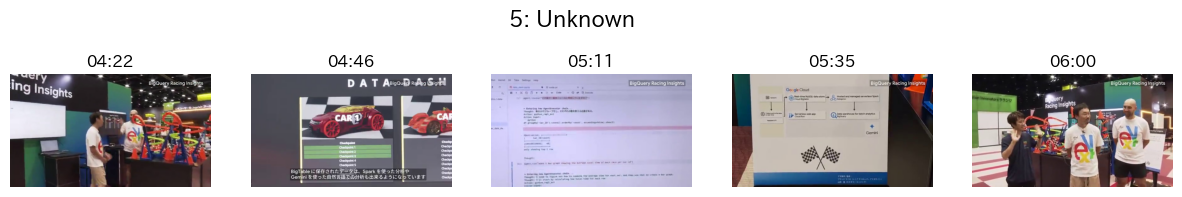

=====
6 Brad Miro Bradさんは白いTシャツに黒いショートパンツを履いています。頭はスキンヘッドです。


<Figure size 640x480 with 0 Axes>

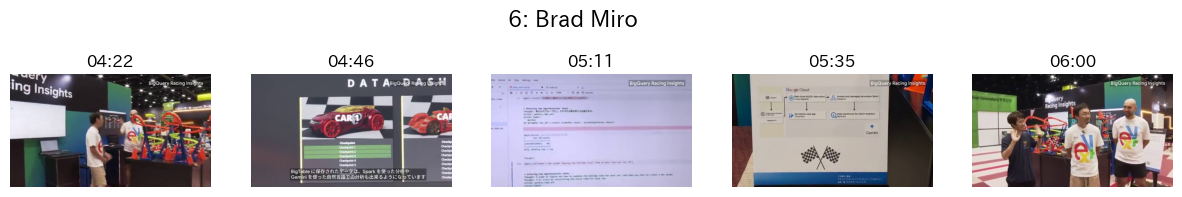

=====
7 Unknown 白いTシャツに黒いパンツを履いています。髪は黒く、肩より少し長いくらいです。


<Figure size 640x480 with 0 Axes>

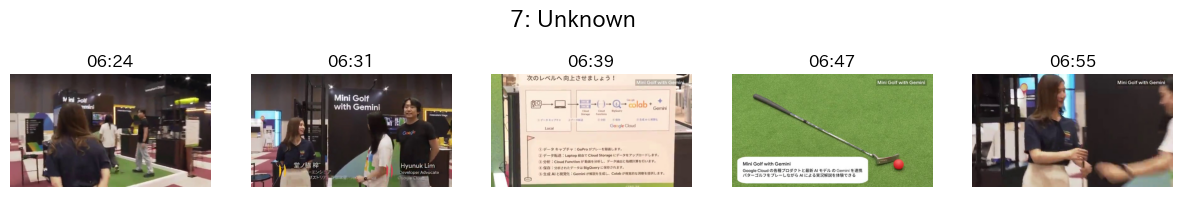

=====
8 Hyunuk Lim Hyunukさんは黒いTシャツにジーンズを履いています。髪は黒く、短髪です。


<Figure size 640x480 with 0 Axes>

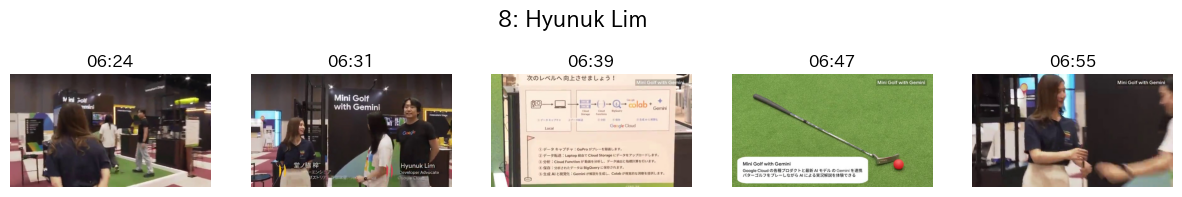

=====
9 Unknown 白いTシャツに黒いパンツを履いています。髪は黒く、肩より少し長いくらいです。


<Figure size 640x480 with 0 Axes>

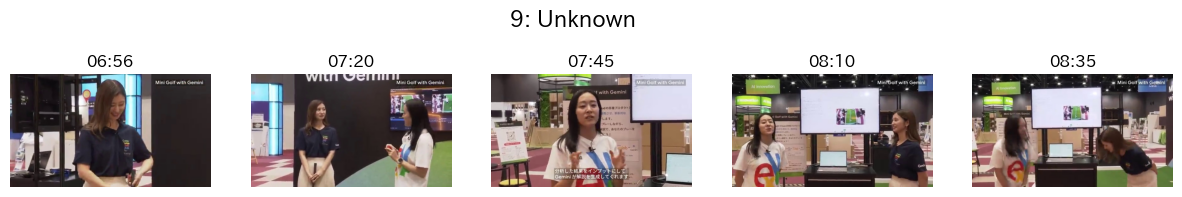

=====
10 Unknown ストライプのシャツを着ています。髪は黒く、短髪です。


<Figure size 640x480 with 0 Axes>

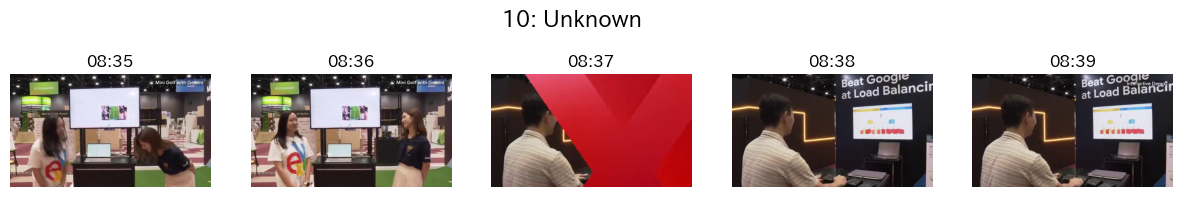

<Figure size 640x480 with 0 Axes>

In [18]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [19]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/Brad Miro.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/Hyunuk Lim.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/佐々木 茜.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/堂ノ脇 梓.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/小栗 香菜恵.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/山田 唯.png',
 'gs://your-project-handson/image/Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -/characters/河野 豪.png']

In [20]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "Brad Miro"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/Google Cloud Next Tokyo \342\200\23124 - Innovators Hive \343\201\256 Day 0 \343\201\253\346\275\234\345\205\245\357\274\201 -/characters/Brad Miro.png"
 },
 'The name of following character is "Hyunuk Lim"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/Google Cloud Next Tokyo \342\200\23124 - Innovators Hive \343\201\256 Day 0 \343\201\253\346\275\234\345\205\245\357\274\201 -/characters/Hyunuk Lim.png"
 },
 'The name of following character is "佐々木 茜"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/Google Cloud Next Tokyo \342\200\23124 - Innovators Hive \343\201\256 Day 0 \343\201\253\346\275\234\345\205\245\357\274\201 -/characters/\344\275\220\343\200\205\346\234\250 \350\214\234.png"
 },
 'The name of following c

## 動画サマリー

In [21]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
In Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

prompt_summary = [prompt_summary] + prompt_reference

In [22]:
result = generate(prompt_summary, model=model)

{
  "Title": "Google Cloud Next Tokyo 24 イノベーターズハイブ潜入取材",
  "Summary": "Google Cloud の河野 豪さんと小栗 香菜恵さんが、パシフィコ横浜ノースで開催される Google Cloud Next Tokyo 24 のイノベーターズハイブエリアを潜入取材します。\nGoogle Cloud の佐々木 茜さんによると、イノベーターズハイブはエンジニアやデベロッパー向けに様々な情報や体験を提供するエリアです。\nChampion Innovators によるライトニングトークを実施する Innovators Stage や、Champion Innovators や Google のエンジニアに技術的な質問をすることができる Ask the Expert、6つのカテゴリーで Google Cloud の知識を試せるクイズチャレンジなどがあります。\n河野 豪さんと小栗 香菜恵さんは、ミニカーのレースデータを取得・分析する BigQuery Racing Insights のブースで山田 唯さんと Brad Miro さんに話を聞きます。\nまた、パターゴルフをプレイしながら AI による実況解説を体験できる Mini Golf with Gemini のブースで堂ノ脇 梓さんと Hyunuk Lim さんに話を聞きます。\nその他にも、ゲームのようにボタンを叩き負荷分散を体験できる Beat Google at Load Balancing のブースや、サーバーレスで動く列車を体験しながらクラウドの仕組みを楽しく学べる Cloud Express Architect のブース、手書きのワイヤーフレームから生成AIを使ってWeb開発の効率をどのように高められるかを紹介する Instant Web with Gemini のブースなどがあります。\n最後に、河野 豪さんと小栗 香菜恵さんは、Google Cloud Next Tokyo 24 に参加する人たちに向けてメッセージを送ります。"
}

In [23]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [24]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [25]:
important_scenes = generate(prompt_important_scenes, model=model)

Timestamp, Description
00:05-00:29, Google Cloud の河野 豪さんと小栗 香菜恵さんが Google Cloud Next Tokyo 24 のイノベーターズハイブエリアの潜入取材について紹介します。
01:29-01:41, Google Cloud の佐々木 茜さんがイノベーターズハイブについて説明します。
01:41-02:09, 佐々木 茜さんが Innovators Stage と Ask the Expert について説明します。
02:09-02:37, 佐々木 茜さんがクイズチャレンジについて説明します。
02:37-02:55, 佐々木 茜さんが Google Cloud Innovators のブースについて説明します。
02:56-03:02, 佐々木 茜さんが認定資格やラーニングプログラムを紹介するブースについて説明します。
03:02-03:24, 佐々木 茜さんが Game Engineers Meetup について説明します。
03:24-03:44, 河野 豪さんと小栗 香菜恵さんが佐々木 茜さんに話を聞きます。
03:54-05:55, 河野 豪さんが BigQuery Racing Insights のブースで山田 唯さんと Brad Miro さんに話を聞きます。
06:22-08:34, 小栗 香菜恵さんが Mini Golf with Gemini のブースで堂ノ脇 梓さんと Hyunuk Lim さんに話を聞きます。
08:36-08:52, インタラクティブデモエリアにある Beat Google at Load Balancing のブースについて説明します。
08:52-09:19, インタラクティブデモエリアにある Cloud Express Architect と Instant Web with Gemini のブースについて説明します。
09:20-09:56, 河野 豪さんと小栗 香菜恵さんが Day Zero の感想を述べます。
09:56-10:02, 河野 豪さんと小栗 香菜恵さんが Google Cloud Next Tokyo 24 に参加する人たちに向けてメッセージを送ります。

## シーン情報（ビジュアル情報）取得

In [26]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

prompt_visuals = [prompt_visuals] + prompt_reference

In [27]:
visual_info = generate(prompt_visuals, model=model)

Timestamp, Description
00:05-00:08, 河野 豪さんと小栗 香菜恵さんが、Google Cloud Nextの看板の前で立っています。2人ともGoogle Cloudのロゴが入った黒いTシャツを着ています。背景には「さあ、新しくクラウドで」と書かれた看板があります。
00:11-00:15, イベント会場の準備風景です。広々とした会場に、赤いカーペットが敷かれています。複数の作業員が、ブースの組み立てや機材の搬入を行っています。
00:19-00:22, イベント会場の準備風景です。ブースの骨組みが組み立てられ、配線作業が行われています。天井には照明が設置され、会場全体が明るく照らされています。
00:27-00:30, イベント会場の準備風景です。ブースの装飾や照明の設置が完了し、華やかな雰囲気になっています。カラフルなネオンサインが輝き、イベントへの期待感を高めています。
00:34-00:38, 河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。2人とも後ろ姿で、河野 豪さんは黒いTシャツ、小栗 香菜恵さんは黒いTシャツに白いスカートを履いています。周囲には、様々なブースが設置されています。
00:38-00:41, 河野 豪さんと小栗 香菜恵さんが、オレンジ色の壁のブースに入っていきます。ブース内には、木製の棚があり、カラフルなバッグやタンブラーが置かれています。
00:41-00:44, 河野 豪さんが、カラフルなバッグを手に取って見ています。小栗 香菜恵さんは、笑顔で河野 豪さんを見ています。バッグは青、黄、ピンクなどのパッチワーク柄で、Google Cloudのロゴが入っています。
00:44-00:48, 河野 豪さんが、バッグを棚に戻し、小栗 香菜恵さんと一緒にブースを出ていきます。ブースの壁には、オレンジ色の塗料が塗られており、明るい雰囲気です。
00:48-00:51, 河野 豪さんと小栗 香菜恵さんが、黒い壁に「ブーススタンブラリー受付」と書かれたブースの前を歩いています。小栗 香菜恵さんは、白いスカートを履いており、河野 豪さんは黒いTシャツを着ています。
00:51-00:56, 河野 豪さんと小栗 香菜恵さんが、大きなディスプレイの前に立っています。ディスプレイには、イベント会場のフロアマッ

## 音声文字起こし

In [28]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

In [29]:
result = generate([prompt_transcription] + prompt_reference, model=model)

```json
[
  {
    "timestamp": "00:06-00:08",
    "Name": "河野 豪",
    "Transcription": "皆さんこんにちは Google Cloud の ゴウです"
  },
  {
    "timestamp": "00:08-00:10",
    "Name": "小栗 香菜恵",
    "Transcription": "こんにちは かなえです"
  },
  {
    "timestamp": "00:10-00:22",
    "Name": "河野 豪",
    "Transcription": "今日はパシフィコ横浜ノースで開催される Google Cloud Next Tokyo 24 のイノベーターズハイブ そのデイゼロ 前日準備の様子を特別に 潜入取材しちゃいます"
  },
  {
    "timestamp": "00:22-00:29",
    "Name": "小栗 香菜恵",
    "Transcription": "普段は見ることのできない イベントの裏側を 大公開しちゃいますので 皆さんぜひ チェックしてみてくださいね"
  },
  {
    "timestamp": "00:31-00:33",
    "Name": "河野 豪",
    "Transcription": "それじゃあ早速 行ってみましょう 行きましょう"
  },
  {
    "timestamp": "00:35-00:38",
    "Name": "小栗 香菜恵",
    "Transcription": "なんか サンプラリーとか サンプラリーとか ありますね"
  },
  {
    "timestamp": "00:44-00:46",
    "Name": "小栗 香菜恵",
    "Transcription": "ええ そうそう"
  },
  {
    "timestamp": "00:46-00:47",
    "Name": "小栗 香菜恵",
    "Transcription": "え すごい"
  },
  {
    "timestamp": "01:22-01:23",
    "Name": "Unknown",

In [30]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [31]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout how text strings are arranged on the screen.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

In [32]:
result = generate(prompt_text_layout, model=model_noaudio)

[
  {
    "Timestamp": "00:06-00:12",
    "Layout": "画面左下に縦書きで2つのテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:45-01:53",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:00-02:09",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:15-02:22",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:26-02:35",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:47-02:55",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "03:17-03:25",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "03:29-03:38",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "04:04-04:13",
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "04:25-04:32",
    "Layout": "画面右下に縦書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "04:37-04:49",
    "Layout": "画面右下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "04:51-05:29",
    "Layout": "画面右上に横書きでテキストブロックが配置されている"
  },

In [33]:
layout_info = load_json(result)

取得した情報から５シーンごとに分割してテキストを抽出する。

In [36]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Process the scenes only within the timestamps described in the [text layout]. Hence the "Timestamp" in the output should be the same as in the [text layout].
A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

In [37]:
merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c+1} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は3回リトライする。
    n = 0
    while n < 3:
        try:
            result = generate(prompt, model=model_noaudio)    
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)


=== Scene 1 to 5 ===
```json
[
  {
    "Timestamp": "00:06-00:12",
    "Text": [
      "齋藤 豪",
      "パートナーデベロップメントマネージャー",
      "Google Cloud"
    ],
    "Layout": "画面左下に縦書きで2つのテキストブロックが配置されている"
  },
  {
    "Timestamp": "00:06-00:12",
    "Text": [
      "小野 香菜恵",
      "パートナーデベロップメントマネージャー",
      "パートナー事業本部, Google Cloud"
    ],
    "Layout": "画面左下に縦書きで2つのテキストブロックが配置されている"
  },
  {
    "Timestamp": "01:45-01:53",
    "Text": [
      "Innovators Hive",
      "デベロッパーエンジニア向けに",
      "さまざまな体験や情報をお届けするエリア"
    ],
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:00-02:09",
    "Text": [
      "Innovators Stage",
      "Champion Innovators による",
      "ライトニングトークを実施",
      "(事前登録不要)"
    ],
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:15-02:22",
    "Text": [
      "Ask the Expert",
      "Google Cloud の技術エキスパートが常駐",
      "技術的なご質問やご相談を"
    ],
    "Layout": "画面左下に横書きでテキストブロックが配置されている"
  },
  {
    "Timestamp": "02:26-02:35",
    "Text"

## テキストベースの動画内検索

In [38]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

In [39]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        # 報告されたタイムスタンプの前後 3 秒を含めて 5 枚の静止画像を表示する
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [44]:
%%time
query = '視聴者の興味を惹く面白そうなシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "03:54-05:55",
    "Description": "このシーンでは、ミニカーのレースデータを取得・分析する BigQuery Racing Insights のブースで、河野 豪さんが山田 唯さんと Brad Miro さんに話を聞いています。ミニカーを実際に走らせてデータを取得し、ジェミニを使って分析するというデモの様子が映し出され、データ分析の幅広さや可能性を感じることができます。視聴者にとって興味深い内容です。",
    "Evidence": [
      "03:54-05:55, 河野 豪さんが BigQuery Racing Insights のブースで山田 唯さんと Brad Miro さんに話を聞きます。",
      "{'Layout': '画面左下に横書きでテキストブロックが配置されている', 'Text': ['BigQuery Racing Insights', 'コースを走るミニカーのデータを取得し', 'BigTable、Spark、Geminiを用いた', '低レイテンシーのリアルタイムデータ分析を体験できる'], 'Timestamp': '04:04-04:13'}"
    ]
  },
  {
    "Timestamp": "06:22-08:34",
    "Description": "このシーンでは、パターゴルフをプレイしながら AI による実況解説を体験できる Mini Golf with Gemini のブースで、小栗 香菜恵さんが堂ノ脇 梓さんと Hyunuk Lim さんに話を聞いています。小栗 香菜恵さんが実際にパターゴルフに挑戦し、AI がそのプレーを分析して実況解説を行う様子が映し出され、視聴者にとって興味深い内容です。",
    "Evidence": [
      "06:22-08:34, 小栗 香菜恵さんが Mini Golf with Gemini のブースで堂ノ脇 梓さんと Hyunuk Lim さんに話を聞きます。",
      "{'Layout': '画面左下に横書きでテキストブロックが配置されている', 'Text': ['Mini Golf with Gemini', 'Google C

=====
このシーンでは、ミニカーのレースデータを取得・分析する BigQuery Racing Insights のブースで、河野 豪さんが山田 唯さんと Brad Miro さんに話を聞いています。ミニカーを実際に走らせてデータを取得し、ジェミニを使って分析するというデモの様子が映し出され、データ分析の幅広さや可能性を感じることができます。視聴者にとって興味深い内容です。


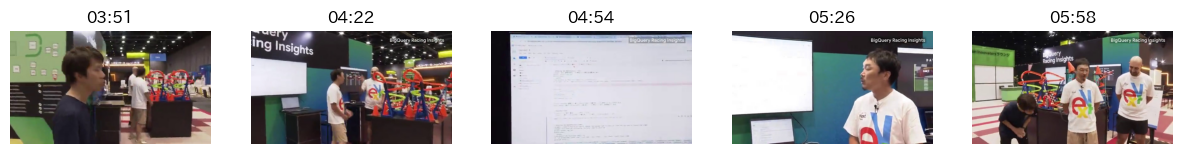

=====
このシーンでは、パターゴルフをプレイしながら AI による実況解説を体験できる Mini Golf with Gemini のブースで、小栗 香菜恵さんが堂ノ脇 梓さんと Hyunuk Lim さんに話を聞いています。小栗 香菜恵さんが実際にパターゴルフに挑戦し、AI がそのプレーを分析して実況解説を行う様子が映し出され、視聴者にとって興味深い内容です。


<Figure size 640x480 with 0 Axes>

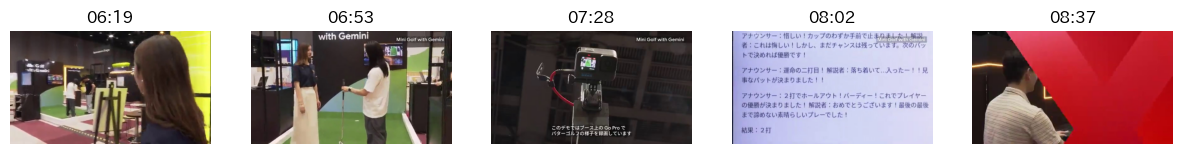

=====
このシーンでは、インタラクティブデモエリアにある Beat Google at Load Balancing のブースや、Cloud Express Architect と Instant Web with Gemini のブースについて説明されています。これらのブースでは、ゲームのようにボタンを叩き負荷分散を体験したり、サーバーレスで動く列車を体験したり、手書きのワイヤーフレームから生成 AI を使って Web 開発の効率をどのように高められるかを紹介するなど、実際に体験しながら Google Cloud 製品について詳しく知ることのできるデモが用意されています。視聴者にとって興味深い内容です。


<Figure size 640x480 with 0 Axes>

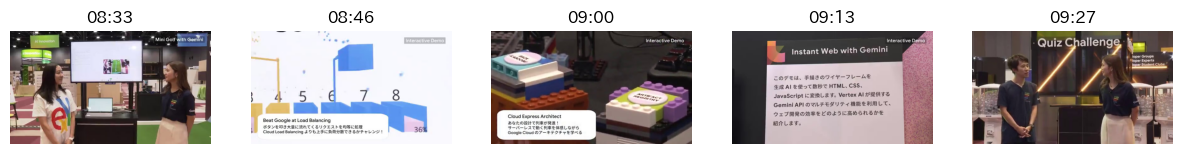

<Figure size 640x480 with 0 Axes>

In [45]:
show_thumbnails(load_json(result))

In [46]:
%%time
query = '複数の人物が会話しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "03:24-03:44",
    "Description": "このシーンでは、河野 豪さんと小栗 香菜恵さんが佐々木 茜さんに質問をしています。3人が会話している様子が確認できます。",
    "Evidence": [
      {
        "Transcription": "なるほど 盛りだくさんですね",
        "timestamp": "03:25-03:27"
      },
      {
        "Transcription": "はい Google Cloud の最新技術を インタラクティブなデモを通して体験いただける 様々なブースも用意してますので ぜひ楽しんでいってください",
        "timestamp": "03:27-03:37"
      },
      {
        "Transcription": "では実際にデモブースに 行ってみたいと思います あかねさん ありがとうございました ありがとうございました ありがとうございました 行ってきます 行ってきます",
        "timestamp": "03:37-03:42"
      },
      {
        "Visual info": "小栗 香菜恵さんが、佐々木 茜さんに質問をしています。佐々木 茜さんは、Google Cloudの最新技術について説明しています。背景には、「Quiz Challenge」と書かれた看板と、カプセルトイの機械が2台置かれています。",
        "timestamp": "03:24-03:44"
      }
    ]
  },
  {
    "Timestamp": "03:54-05:55",
    "Description": "このシーンでは、河野 豪さんが BigQuery Racing Insights のブースで山田 唯さんと Brad Miro さんに話を聞いています。3人が会話している様子が確認できます。",
    "Evidence": [
      {
        "Transcription": "お 車のサーキットみたいなのがありますね ちょっと見ていきましょ

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんが佐々木 茜さんに質問をしています。3人が会話している様子が確認できます。


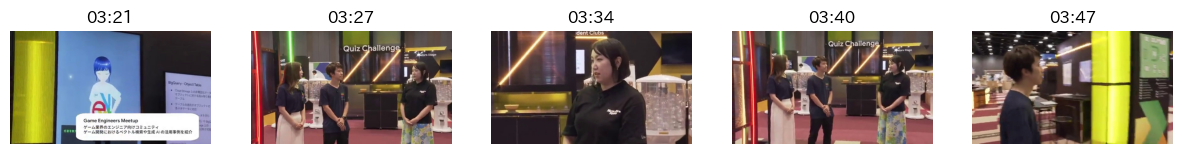

=====
このシーンでは、河野 豪さんが BigQuery Racing Insights のブースで山田 唯さんと Brad Miro さんに話を聞いています。3人が会話している様子が確認できます。


<Figure size 640x480 with 0 Axes>

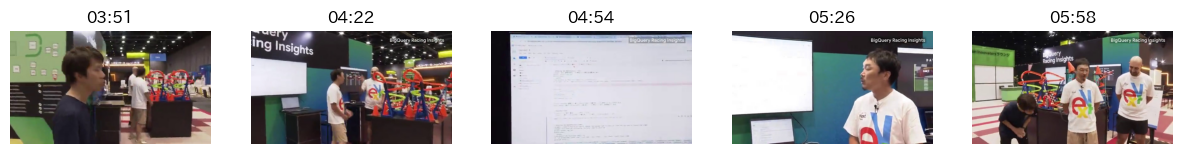

=====
このシーンでは、小栗 香菜恵さんが Mini Golf with Gemini のブースで堂ノ脇 梓さんと Hyunuk Lim さんに話を聞いています。3人が会話している様子が確認できます。


<Figure size 640x480 with 0 Axes>

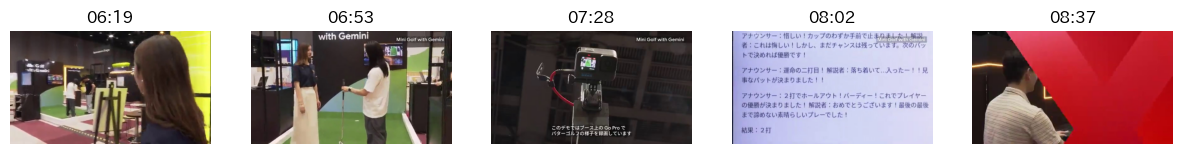

<Figure size 640x480 with 0 Axes>

In [47]:
show_thumbnails(load_json(result))

In [48]:
%%time
query = '会場を歩いているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:34-00:38",
    "Description": "このシーンでは、河野 豪さんと小栗 香菜恵さんがイベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。",
    "Evidence": [
      "00:34-00:38, 河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。2人とも後ろ姿で、河野 豪さんは黒いTシャツ、小栗 香菜恵さんは黒いTシャツに白いスカートを履いています。周囲には、様々なブースが設置されています。"
    ]
  },
  {
    "Timestamp": "00:48-00:51",
    "Description": "このシーンでは、河野 豪さんと小栗 香菜恵さんが、黒い壁に「ブーススタンブラリー受付」と書かれたブースの前を歩いています。",
    "Evidence": [
      "00:48-00:51, 河野 豪さんと小栗 香菜恵さんが、黒い壁に「ブーススタンブラリー受付」と書かれたブースの前を歩いています。小栗 香菜恵さんは、白いスカートを履いており、河野 豪さんは黒いTシャツを着ています。"
    ]
  },
  {
    "Timestamp": "00:56-00:59",
    "Description": "このシーンでは、河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。",
    "Evidence": [
      "00:56-00:59, 河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。2人とも後ろ姿で、河野 豪さんは黒いTシャツ、小栗 香菜恵さんは黒いTシャツに白いスカートを履いています。周囲には、様々なブースが設置されています。"
    ]
  },
  {
    "Timestamp": "01:07-01:10",
    "Description": "このシーンでは、河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。",
    "

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんがイベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


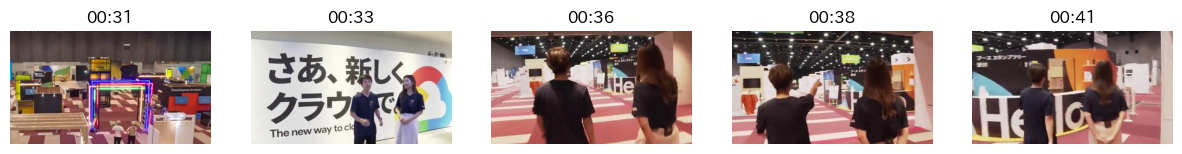

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんが、黒い壁に「ブーススタンブラリー受付」と書かれたブースの前を歩いています。


<Figure size 640x480 with 0 Axes>

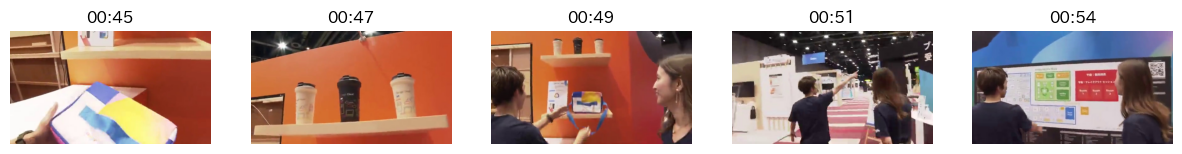

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


<Figure size 640x480 with 0 Axes>

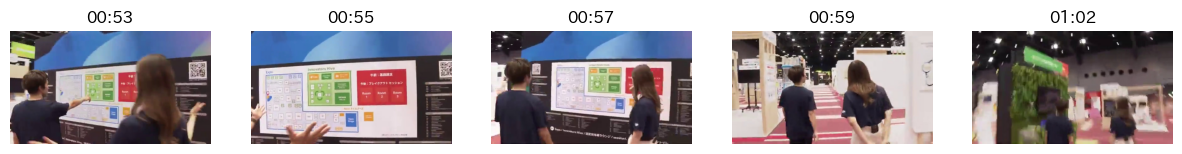

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


<Figure size 640x480 with 0 Axes>

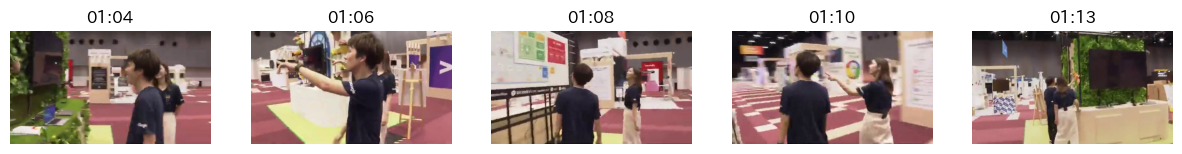

=====
このシーンでは、河野 豪さんと小栗 香菜恵さんが、イベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


<Figure size 640x480 with 0 Axes>

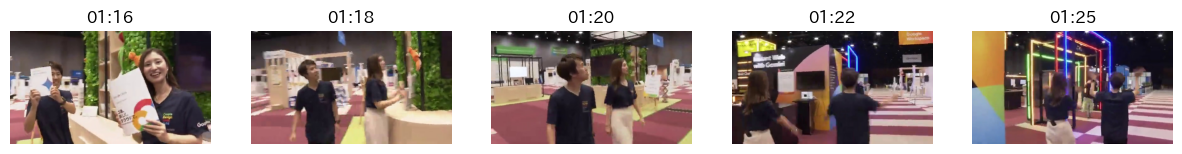

=====
このシーンでは、河野 豪さんが「さあ 到着しました ここが イノベーターズハイブのエリアです」と発言しており、河野 豪さんと小栗 香菜恵さんがイノベーターズハイブエリアに到着したことがわかります。


<Figure size 640x480 with 0 Axes>

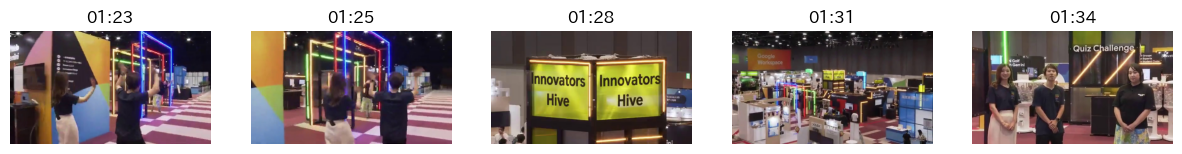

=====
このシーンでは、河野 豪さんがイベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


<Figure size 640x480 with 0 Axes>

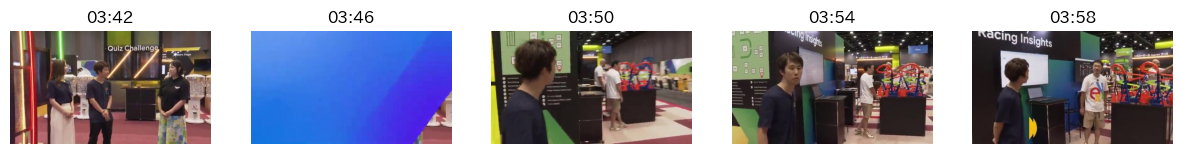

=====
このシーンでは、小栗 香菜恵さんがイベント会場内を歩いています。周囲には様々なブースが設置されており、会場を歩いている様子がわかります。


<Figure size 640x480 with 0 Axes>

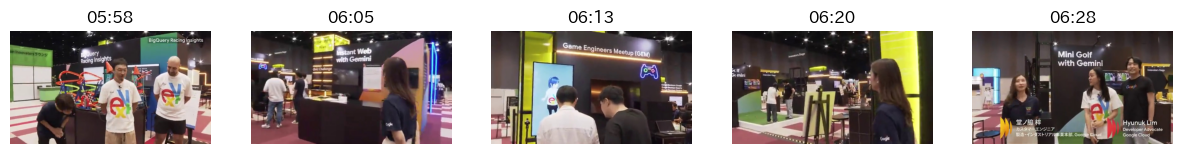

<Figure size 640x480 with 0 Axes>

In [49]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [54]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

In [55]:
%%time
query = '視聴者の興味を惹く面白そうなシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "03:57-05:55",
    "Description": "河野さんがミニカーのサーキットでデータ分析を体験するシーンです。山田さんとBradさんが説明しています。ミニカーの走行データをリアルタイムに取得し、日本語で指示を出すだけで簡単に分析できる様子がわかります。"
  },
  {
    "Timestamp": "06:22-08:34",
    "Description": "小栗さんがパターゴルフを体験するシーンです。堂ノ脇さんとHyunukさんが説明しています。ジェミニというAIモデルを活用し、パターゴルフの様子を撮影した動画から、ボールの軌道や速度などを分析し、解説を作成する様子がわかります。"
  }
]CPU times: user 73.5 ms, sys: 11.1 ms, total: 84.6 ms
Wall time: 20.6 s


=====
河野さんがミニカーのサーキットでデータ分析を体験するシーンです。山田さんとBradさんが説明しています。ミニカーの走行データをリアルタイムに取得し、日本語で指示を出すだけで簡単に分析できる様子がわかります。


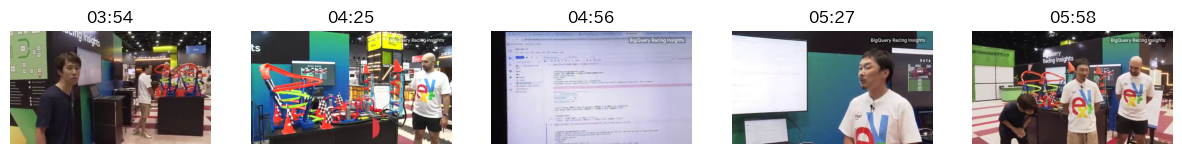

=====
小栗さんがパターゴルフを体験するシーンです。堂ノ脇さんとHyunukさんが説明しています。ジェミニというAIモデルを活用し、パターゴルフの様子を撮影した動画から、ボールの軌道や速度などを分析し、解説を作成する様子がわかります。


<Figure size 640x480 with 0 Axes>

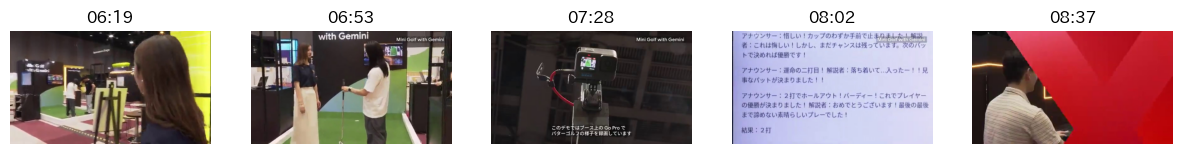

<Figure size 640x480 with 0 Axes>

In [56]:
show_thumbnails(load_json(result))

In [57]:
%%time
query = '複数の人物が会話しているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "01:31-03:44",
    "Description": "河野さんと小栗さんが、佐々木茜さんとミニカーのサーキットのデモを行っている山田唯さん、Brad Miroさんの3人で会話しています。"
  },
  {
    "Timestamp": "06:22-08:35",
    "Description": "小栗さんと堂ノ脇梓さん、Hyunuk Limさんの3人で会話しています。"
  }
]CPU times: user 42.9 ms, sys: 37.6 ms, total: 80.6 ms
Wall time: 21.5 s


=====
河野さんと小栗さんが、佐々木茜さんとミニカーのサーキットのデモを行っている山田唯さん、Brad Miroさんの3人で会話しています。


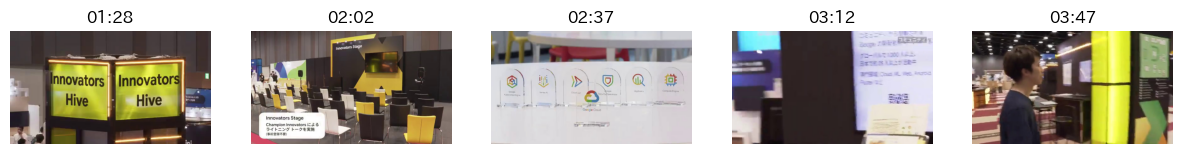

=====
小栗さんと堂ノ脇梓さん、Hyunuk Limさんの3人で会話しています。


<Figure size 640x480 with 0 Axes>

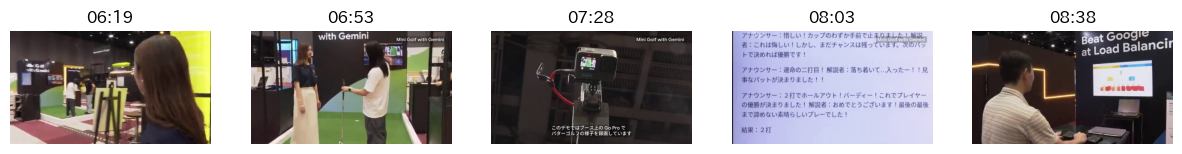

<Figure size 640x480 with 0 Axes>

In [58]:
show_thumbnails(load_json(result))

In [ ]:
%%time
query = '会場を歩いているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

In [ ]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [ ]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [ ]:
!gsutil cp "{metafile}" {BUCKET}/metadata/